### Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import great_circle

In [2]:
# Load Part 1: Bike Stations Data
bike_stations_df = pd.read_csv('bike_stations.csv')

In [3]:
# Load Part 2: Combined Foursquare and Yelp POIs Data
foursquare_df = pd.read_csv('foursquare_pois.csv')
yelp_df = pd.read_csv('yelp_pois.csv')

In [4]:
# Add source columns
foursquare_df['source'] = 'foursquare'
yelp_df['source'] = 'yelp'

In [5]:
# Combine both datasets
pois_df = pd.concat([foursquare_df, yelp_df], ignore_index=True).drop_duplicates(subset='restaurant_name')

In [6]:
# Initialize lists to hold the nearest bike station data
nearest_station_names = []
nearest_station_distances = []

In [7]:
# Define a function to find the nearest bike station
def find_nearest_bike_station(poi_lat, poi_lon):
    distances = bike_stations_df.apply(
        lambda row: great_circle((poi_lat, poi_lon), (row['bike_station_latitude'], row['bike_station_longitude'])).meters,
        axis=1
    )
    nearest_index = distances.idxmin()
    nearest_distance = distances.min()
    nearest_station = bike_stations_df.iloc[nearest_index]['bike_station_name']
    return nearest_station, nearest_distance

In [8]:
# Calculate the nearest bike station for each POI
for _, poi in pois_df.iterrows():
    nearest_station_name, nearest_station_distance = find_nearest_bike_station(poi['restaurant_latitude'], poi['restaurant_longitude'])
    nearest_station_names.append(nearest_station_name)
    nearest_station_distances.append(nearest_station_distance)

In [9]:
# Add the nearest bike station information to the POIs DataFrame
pois_df['nearest_bike_station'] = nearest_station_names
pois_df['distance_to_nearest_station'] = nearest_station_distances

In [10]:
# Join the data by merging on the nearest bike station
final_df = pd.merge(pois_df, bike_stations_df, how='inner', left_on='nearest_bike_station', right_on='bike_station_name')

In [11]:
# Rename columns for clarity
final_df.rename(columns={
    'restaurant_name': 'poi_name',
    'rating': 'poi_rating',
    'price': 'poi_price',
    'category': 'poi_category',
    'address': 'poi_address',
    'restaurant_latitude': 'poi_latitude',
    'restaurant_longitude': 'poi_longitude'
}, inplace=True)

In [12]:
# Select relevant columns for the final DataFrame
final_df = final_df[[
    'poi_name', 'poi_rating', 'poi_price', 'poi_category', 'poi_address',
    'poi_latitude', 'poi_longitude', 'source',
    'nearest_bike_station', 'distance_to_nearest_station',
    'bike_station_name', 'bike_station_latitude', 'bike_station_longitude', 'number_of_bikes'
]]

#### Data Auditing

In [13]:
# Check for missing values
missing_values = final_df.isnull().sum()

In [14]:
# Check for duplicates
duplicates_count = final_df.duplicated().sum()

In [15]:
# Review data types and statistical summaries
data_types = final_df.dtypes
summary_statistics = final_df.describe(include='all')

In [16]:
# Print auditing results
print("### Data Auditing Results ###\n")
print("Missing Values per Column:")
print(missing_values)
print("\nTotal Duplicates:", duplicates_count)
print("\nData Types:")
print(data_types)
print("\nStatistical Summary:")
print(summary_statistics)

### Data Auditing Results ###

Missing Values per Column:
poi_name                         0
poi_rating                      26
poi_price                      244
poi_category                     0
poi_address                     27
poi_latitude                     0
poi_longitude                    0
source                           0
nearest_bike_station             0
distance_to_nearest_station      0
bike_station_name                0
bike_station_latitude            0
bike_station_longitude           0
number_of_bikes                  0
dtype: int64

Total Duplicates: 0

Data Types:
poi_name                        object
poi_rating                     float64
poi_price                       object
poi_category                    object
poi_address                     object
poi_latitude                   float64
poi_longitude                  float64
source                          object
nearest_bike_station            object
distance_to_nearest_station    float64
bike_station_na

#### Data Cleaning

In [17]:
# Remove duplicates
final_df_clean = final_df.drop_duplicates()

In [18]:
# Fill missing categories with "Unknown"
final_df_clean['poi_category'] = final_df_clean['poi_category'].fillna('Unknown')

In [19]:
# Fill missing prices with "Unknown"
final_df_clean['poi_price'] = final_df_clean['poi_price'].fillna('Unknown')

In [20]:
# Fill missing address with "Unknown"
final_df_clean['poi_address'] = final_df_clean['poi_address'].fillna('Unknown')

In [21]:
# Remove rows where essential data like 'poi_name' or 'poi_rating' is missing
final_df_clean = final_df_clean[final_df_clean['poi_name'].notnull() & final_df_clean['poi_rating'].notnull()]

In [22]:
# Convert data types
# Ensure that the latitude and longitude columns are floats
final_df_clean['poi_latitude'] = final_df_clean['poi_latitude'].astype(float)
final_df_clean['poi_longitude'] = final_df_clean['poi_longitude'].astype(float)
final_df_clean['bike_station_latitude'] = final_df_clean['bike_station_latitude'].astype(float)
final_df_clean['bike_station_longitude'] = final_df_clean['bike_station_longitude'].astype(float)

In [23]:
# Save the cleaned DataFrame to a new CSV file
final_df_clean.to_csv('cleaned_bike_stations_pois.csv', index=False)

In [24]:
# Verify the cleaned data
print("\n### Data Cleaning Results ###\n")
print("Cleaned DataFrame Summary:")
print(final_df_clean.info())
print("\nMissing Values after Cleaning:")
print(final_df_clean.isnull().sum())
print("\nSample Data:")
print(final_df_clean.head())


### Data Cleaning Results ###

Cleaned DataFrame Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 632
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   poi_name                     607 non-null    object 
 1   poi_rating                   607 non-null    float64
 2   poi_price                    607 non-null    object 
 3   poi_category                 607 non-null    object 
 4   poi_address                  607 non-null    object 
 5   poi_latitude                 607 non-null    float64
 6   poi_longitude                607 non-null    float64
 7   source                       607 non-null    object 
 8   nearest_bike_station         607 non-null    object 
 9   distance_to_nearest_station  607 non-null    float64
 10  bike_station_name            607 non-null    object 
 11  bike_station_latitude        607 non-null    float64
 12  bike_station_longitude  

#### Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discovered through this visualization. 

In [25]:
# Load the cleaned data
final_df_clean = pd.read_csv('cleaned_bike_stations_pois.csv')

In [26]:
# Set the plot style
sns.set_style("whitegrid")

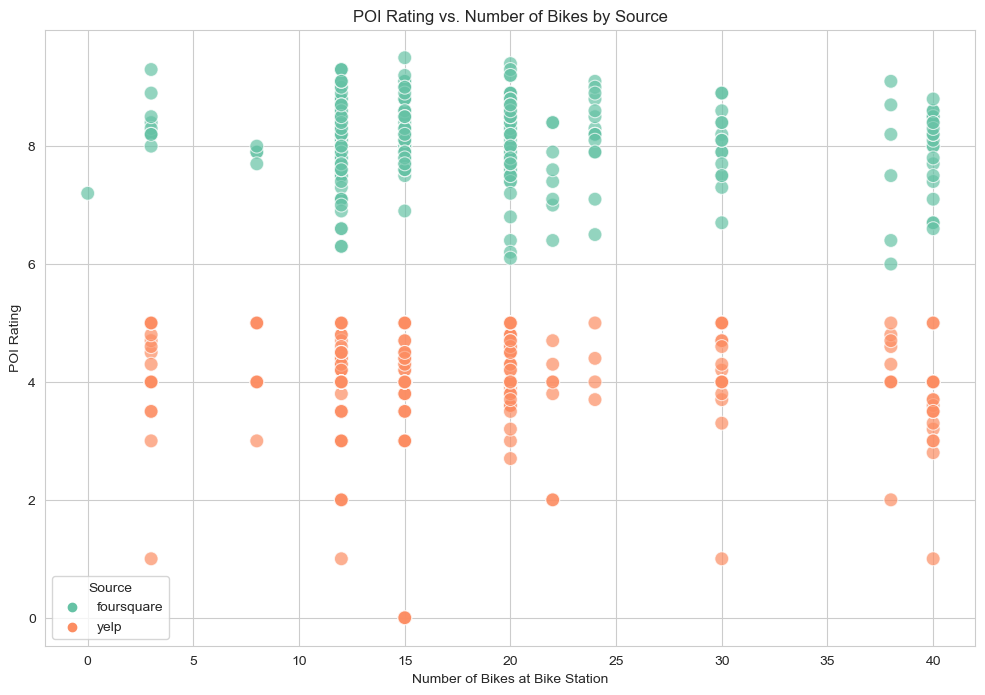

In [27]:
# Scatter plot of POI Rating vs. Number of Bikes
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=final_df_clean,
    x='number_of_bikes',
    y='poi_rating',
    hue='source',
    palette='Set2',
    s=100,
    alpha=0.7
)
plt.title('POI Rating vs. Number of Bikes by Source')
plt.xlabel('Number of Bikes at Bike Station')
plt.ylabel('POI Rating')
plt.legend(title='Source')
plt.grid(True)
plt.show()

### Visualization: POI Rating vs. Number of Bikes

The scatter plot above shows the relationship between POI ratings and the number of bikes at bike stations. Each point represents a POI, and the color indicates whether it was sourced from Foursquare or Yelp. Foursquare uses a 10-point rating scale and and Yelp uses a 5-point rating scale. The scales were left unchanged for this visualization so the data points will not overlap, allowing the patterns to be more easily visible. The analysis below takes this into account.

#### Pattern Observed:
- **Higher Ratings Near More Bikes:** There seems to be a positive correlation between the number of bikes at a station and POI ratings.
- **Foursquare vs. Yelp Differences:**
  - **Foursquare:** Shows more diversity in ratings.
  - **Yelp:** Tends to have higher average ratings compared to Foursquare.

#### Insights:
- **POIs Near Popular Bike Stations:** POIs near bike stations with more bikes often have higher ratings, possibly due to better accessibility or higher foot traffic.
- **Source Differences:** The difference in ratings between Foursquare and Yelp suggests different user demographics or review behaviors.

### SQL Database

In [28]:
import sqlite3

In [29]:
# Create a connection to the SQLite database
# It doesn't matter if the database doesn't yet exist
conn = sqlite3.connect('my_database.db')

In [30]:
# Load CSV data into Pandas DataFrames
bike_stations = pd.read_csv('bike_stations.csv')
combined_pois = pd.read_csv('combined_pois.csv')
cleaned_bike_stations_pois = pd.read_csv('cleaned_bike_stations_pois.csv')

In [31]:
# Write the data from the DataFrame to the SQLite database
bike_stations.to_sql('bike_stations', conn, if_exists='replace', index=False)
combined_pois.to_sql('combined_pois', conn, if_exists='replace', index=False)
cleaned_bike_stations_pois.to_sql('cleaned_bike_stations_pois', conn, if_exists='replace', index=False)

607

In [32]:
# Close the connection
conn.close()

### Validate Data

#### Before the Join

In [34]:
# Connect to the SQLite database
conn = sqlite3.connect('my_database.db')

In [35]:
# Row counts of individual tables
bike_stations_count_query = "SELECT COUNT(*) AS count FROM bike_stations;"
combined_count_query = "SELECT COUNT(*) AS count FROM combined_pois;"

bike_stations_count = pd.read_sql_query(bike_stations_count_query, conn)
combined_count = pd.read_sql_query(combined_count_query, conn)

# Check missing values in individual tables
bike_stations_missing_query = """
    SELECT
        COUNT(*) AS total,
        SUM(CASE WHEN bike_station_name IS NULL THEN 1 ELSE 0 END) AS missing_name,
        SUM(CASE WHEN bike_station_latitude IS NULL THEN 1 ELSE 0 END) AS missing_latitude,
        SUM(CASE WHEN bike_station_longitude IS NULL THEN 1 ELSE 0 END) AS missing_longitude,
        SUM(CASE WHEN number_of_bikes IS NULL THEN 1 ELSE 0 END) AS missing_bikes
    FROM bike_stations;
"""

combined_missing_query = """
    SELECT
        COUNT(*) AS total,
        SUM(CASE WHEN restaurant_name IS NULL THEN 1 ELSE 0 END) AS missing_name,
        SUM(CASE WHEN restaurant_latitude IS NULL THEN 1 ELSE 0 END) AS missing_latitude,
        SUM(CASE WHEN restaurant_longitude IS NULL THEN 1 ELSE 0 END) AS missing_longitude,
        SUM(CASE WHEN rating IS NULL THEN 1 ELSE 0 END) AS missing_rating,
        SUM(CASE WHEN price IS NULL THEN 1 ELSE 0 END) AS missing_price,
        SUM(CASE WHEN category IS NULL THEN 1 ELSE 0 END) AS missing_category,
        SUM(CASE WHEN address IS NULL THEN 1 ELSE 0 END) AS missing_address
    FROM combined_pois;
"""

bike_stations_missing = pd.read_sql_query(bike_stations_missing_query, conn)
combined_missing = pd.read_sql_query(combined_missing_query, conn)


In [36]:
print('Missing values in bike_stations table:\n')
print(bike_stations_missing)
print('Missing values in combined_pois table:\n')
print(combined_missing)

Missing values in bike_stations table:

   total  missing_name  missing_latitude  missing_longitude  missing_bikes
0     46             0                 0                  0              0
Missing values in combined_pois table:

   total  missing_name  missing_latitude  missing_longitude  missing_rating  \
0    634             0                 0                  0              26   

   missing_price  missing_category  missing_address  
0            246                 0               27  


#### Join

In [37]:
# Join query
join_query = """
    SELECT
        bs.bike_station_name,
        bs.bike_station_latitude,
        bs.bike_station_longitude,
        bs.number_of_bikes,
        poi.restaurant_name,
        poi.rating,
        poi.price,
        poi.category,
        poi.address,
        poi.restaurant_latitude,
        poi.restaurant_longitude
    FROM combined_pois poi
    JOIN bike_stations bs
    ON ABS(bs.bike_station_latitude - poi.restaurant_latitude) < 0.01
    AND ABS(bs.bike_station_longitude - poi.restaurant_longitude) < 0.01
"""

final_joined_df = pd.read_sql_query(join_query, conn)

#### After the Join

In [38]:
# Check row count after join
joined_row_count = len(final_joined_df)

# Check missing values in joined table
joined_missing_values = final_joined_df.isnull().sum()

# Print validation results
print(f"Joined Table Count: {joined_row_count}")
print("\nJoined Table Missing Values:")
print(joined_missing_values)

Joined Table Count: 2133

Joined Table Missing Values:
bike_station_name           0
bike_station_latitude       0
bike_station_longitude      0
number_of_bikes             0
restaurant_name             0
rating                     46
price                     746
category                    0
address                    65
restaurant_latitude         0
restaurant_longitude        0
dtype: int64


### Analysis

#### Row Count Increase
The row count increased from 634 (POIs) to 2133 in the joined table due to multiple POIs per bike station.

#### Missing Data Analysis
#### Rating
- **Before Join:** 26 POIs were missing ratings.
- **After Join:** 46 POIs are missing ratings.
- **Reason:** Some bike stations have multiple POIs, leading to more rows with missing ratings.

#### Price
- **Before Join:** 246 POIs were missing price data.
- **After Join:** 746 rows are missing price data.
- **Reason:** The join operation led to the replication of POIs, resulting in more rows with missing price data.

#### Address
- **Before Join:** 27 POIs were missing addresses.
- **After Join:** 65 rows are missing addresses.
- **Reason:** Similar to the above, replication of POIs due to the join operation resulted in more rows with missing addresses.